In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import pandas as pd
!pip install git+https://github.com/hpamula/tsproto.git
from tsproto.utils import getshap
from sklearn.model_selection import train_test_split

  Cloning https://github.com/hpamula/tsproto.git to /tmp/pip-req-build-iecjrysl
  Running command git clone --filter=blob:none --quiet https://github.com/hpamula/tsproto.git /tmp/pip-req-build-iecjrysl
  Resolved https://github.com/hpamula/tsproto.git to commit 504b6f61785c629e1bbb8f7cf8aa1af2d8cbd5f6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 21.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.3/476.3 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

## Creating synthetic dataset
We will create a synthetic dataset with two classes. The dataset will be hard to distinguish based on statistical features, but possible with proper prototypical parts extracted.

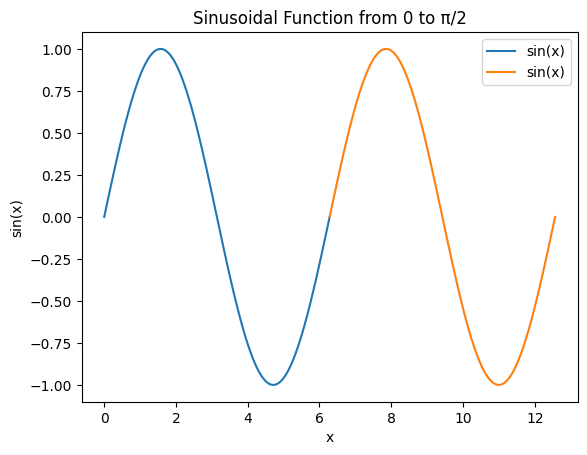

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to π/2
x1 = np.linspace(0, 2*np.pi, 100)
x2 = np.linspace(2*np.pi, 4*np.pi, 100)

# Calculate y values for the sinusoidal function
y1 = np.sin(x1)
y2 = np.sin(x2)

# Plotting the sinusoidal function
plt.plot(x1, y1, label='sin(x)')
plt.plot(x2, y2, label='sin(x)')
plt.title('Sinusoidal Function from 0 to π/2')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

In [6]:
X3 = np.concatenate((x1,x2))
Y3 = np.concatenate((y1,y2))

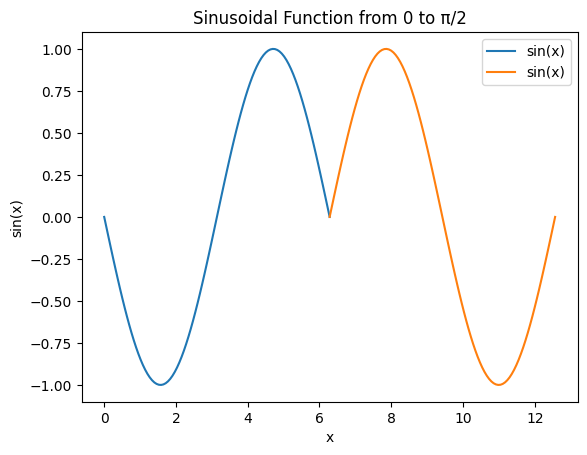

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to π/2
x1 = np.linspace(0, 2*np.pi, 100)
x2 = np.linspace(2*np.pi, 4*np.pi, 100)

# Calculate y values for the sinusoidal function
y1 = np.sin(-x1)
y2 = np.sin(x2)

# Plotting the sinusoidal function
plt.plot(x1, y1, label='sin(x)')
plt.plot(x2, y2, label='sin(x)')
plt.title('Sinusoidal Function from 0 to π/2')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

In [8]:
X4 = np.concatenate((x1,x2))
Y4 = np.concatenate((y1,y2))

## Generating sample cases
The difference is in the begining.

In [9]:
x = X3
proto_sin_y = Y3
proto_inversed_sin_y = Y4

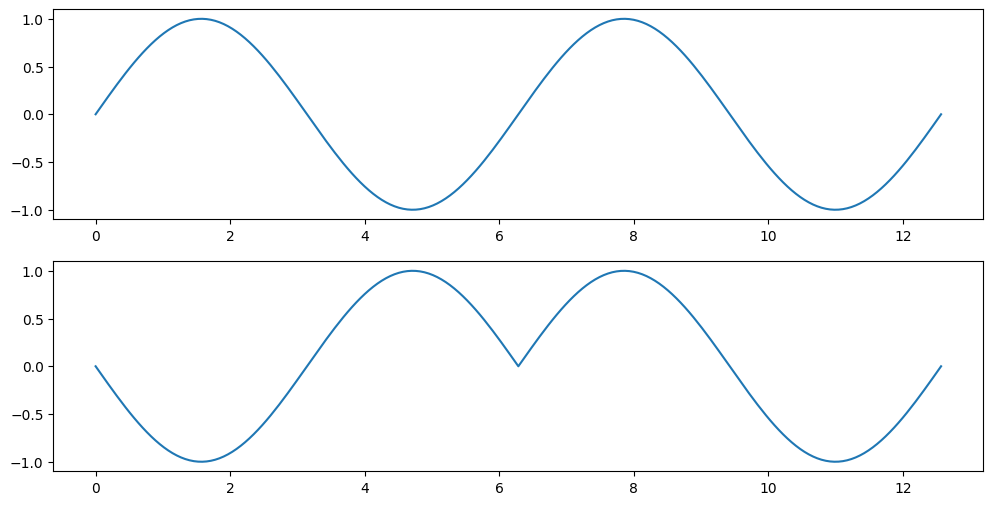

In [10]:
fig, axes =plt.subplots(2,1,figsize=(12,6))
axes[0].plot(x,proto_sin_y)
axes[1].plot(x,proto_inversed_sin_y)

## Generating noise and augmenting signals

In [11]:
noise_power = .9

In [12]:
noise = (np.random.rand(100,len(x))-0.5)*noise_power
noisy_proto_sin_y = noise + proto_sin_y

In [13]:
noise = (np.random.rand(100,len(x))-0.5)*noise_power
noisy_proto_inversed_sin_y = noise + proto_inversed_sin_y

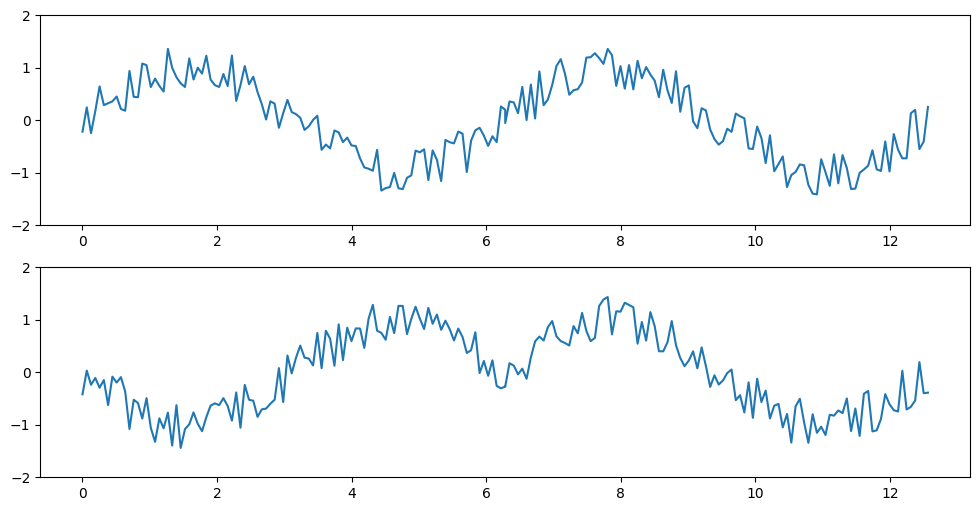

In [14]:
fig, axes =plt.subplots(2,1,figsize=(12,6))
axes[0].plot(x,noisy_proto_sin_y[0])
axes[1].plot(x,noisy_proto_inversed_sin_y[0])
for ax in axes:
    ax.set_ylim([-2, 2])

In [15]:
X=np.concatenate((noisy_proto_sin_y,noisy_proto_inversed_sin_y))
Xy=np.concatenate((np.ones(len(noisy_proto_sin_y))*0,
                   np.ones(len(noisy_proto_inversed_sin_y))*1))

trainX, testX, train_y,test_y = train_test_split(X,Xy)

## Model
We will build simple DNN model (not really needed in this case, but it serves the purpose of demonstration how to deal with more complex cases)

In [16]:
from keras.utils import to_categorical
trainXnn = trainX.reshape(150,1,200)
train_ynn = to_categorical(train_y)
num_classes = len(np.unique(Xy))

In [17]:
import keras
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    #add dropout
    input_layer = keras.layers.Dropout(0.5)(input_layer)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(input_layer)
    #conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(conv1)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(conv2)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)



model = make_model(input_shape=trainXnn.shape[1:])

In [18]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_crossentropy"],
)
history = model.fit(
    trainXnn,
    train_ynn,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - categorical_crossentropy: 0.6853 - loss: 0.6853

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - categorical_crossentropy: 0.6840 - loss: 0.6840 - val_categorical_crossentropy: 0.6436 - val_loss: 0.6436 - learning_rate: 0.0010
Epoch 2/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 0.6440 - loss: 0.6440

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 0.6233 - loss: 0.6233 - val_categorical_crossentropy: 0.5258 - val_loss: 0.5258 - learning_rate: 0.0010
Epoch 3/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 0.5265 - loss: 0.5265

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 0.4873 - loss: 0.4873 - val_categorical_crossentropy: 0.3269 - val_loss: 0.3269 - learning_rate: 0.0010
Epoch 4/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 0.3272 - loss: 0.3272

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 0.2801 - loss: 0.2801 - val_categorical_crossentropy: 0.1205 - val_loss: 0.1205 - learning_rate: 0.0010
Epoch 5/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 0.1213 - loss: 0.1213

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 0.0932 - loss: 0.0932 - val_categorical_crossentropy: 0.0224 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 6/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 0.0221 - loss: 0.0221

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 0.0161 - loss: 0.0161 - val_categorical_crossentropy: 0.0029 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 7/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 0.0029 - loss: 0.0029

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - categorical_crossentropy: 0.0021 - loss: 0.0021 - val_categorical_crossentropy: 4.3124e-04 - val_loss: 4.3124e-04 - learning_rate: 0.0010
Epoch 8/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_crossentropy: 4.3513e-04 - loss: 4.3513e-04

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_crossentropy: 3.2906e-04 - loss: 3.2906e-04 - val_categorical_crossentropy: 8.7519e-05 - val_loss: 8.7519e-05 - learning_rate: 0.0010
Epoch 9/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_crossentropy: 9.0792e-05 - loss: 9.0792e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - categorical_crossentropy: 7.1435e-05 - loss: 7.1435e-05 - val_categorical_crossentropy: 2.5387e-05 - val_loss: 2.5387e-05 - learning_rate: 0.0010
Epoch 10/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 2.6650e-05 - loss: 2.6650e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_crossentropy: 2.1782e-05 - loss: 2.1782e-05 - val_categorical_crossentropy: 1.0065e-05 - val_loss: 1.0065e-05 - learning_rate: 0.0010
Epoch 11/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - categorical_crossentropy: 1.0863e-05 - loss: 1.0863e-05

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_crossentropy: 9.0764e-06 - loss: 9.0764e-06 - val_categorical_crossentropy: 5.1220e-06 - val_loss: 5.1220e-06 - learning_rate: 0.0010
Epoch 12/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 5.2079e-06 - loss: 5.2079e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 4.7157e-06 - loss: 4.7157e-06 - val_categorical_crossentropy: 3.1749e-06 - val_loss: 3.1749e-06 - learning_rate: 0.0010
Epoch 13/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - categorical_crossentropy: 2.9765e-06 - loss: 2.9765e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - categorical_crossentropy: 2.9566e-06 - loss: 2.9566e-06 - val_categorical_crossentropy: 2.2451e-06 - val_loss: 2.2451e-06 - learning_rate: 0.0010
Epoch 14/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - categorical_crossentropy: 2.1756e-06 - loss: 2.1756e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_crossentropy: 2.1745e-06 - loss: 2.1745e-06 - val_categorical_crossentropy: 1.7643e-06 - val_loss: 1.7643e-06 - learning_rate: 0.0010
Epoch 15/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.7472e-06 - loss: 1.7472e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.7507e-06 - loss: 1.7507e-06 - val_categorical_crossentropy: 1.5020e-06 - val_loss: 1.5020e-06 - learning_rate: 0.0010
Epoch 16/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.5274e-06 - loss: 1.5274e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.5077e-06 - loss: 1.5077e-06 - val_categorical_crossentropy: 1.3351e-06 - val_loss: 1.3351e-06 - learning_rate: 0.0010
Epoch 17/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.4976e-06 - loss: 1.4976e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.4007e-06 - loss: 1.4007e-06 - val_categorical_crossentropy: 1.2318e-06 - val_loss: 1.2318e-06 - learning_rate: 0.0010
Epoch 18/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 1.2405e-06 - loss: 1.2405e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2519e-06 - loss: 1.2519e-06 - val_categorical_crossentropy: 1.1722e-06 - val_loss: 1.1722e-06 - learning_rate: 0.0010
Epoch 19/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.2815e-06 - loss: 1.2815e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.2230e-06 - loss: 1.2230e-06 - val_categorical_crossentropy: 1.1325e-06 - val_loss: 1.1325e-06 - learning_rate: 0.0010
Epoch 20/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.1474e-06 - loss: 1.1474e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1519e-06 - loss: 1.1519e-06 - val_categorical_crossentropy: 1.0928e-06 - val_loss: 1.0928e-06 - learning_rate: 0.0010
Epoch 21/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.0543e-06 - loss: 1.0543e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.1071e-06 - loss: 1.1071e-06 - val_categorical_crossentropy: 1.0729e-06 - val_loss: 1.0729e-06 - learning_rate: 0.0010
Epoch 22/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 9.9838e-07 - loss: 9.9838e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.0750e-06 - loss: 1.0750e-06 - val_categorical_crossentropy: 1.0610e-06 - val_loss: 1.0610e-06 - learning_rate: 0.0010
Epoch 23/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0898e-06 - loss: 1.0898e-06 - val_categorical_crossentropy: 1.0610e-06 - val_loss: 1.0610e-06 - learning_rate: 0.0010
Epoch 24/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.0692e-06 - loss: 1.0692e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0671e-06 - loss: 1.0671e-06 - val_categorical_crossentropy: 1.0530e-06 - val_loss: 1.0530e-06 - learning_rate: 0.0010
Epoch 25/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.0394e-06 - loss: 1.0394e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0844e-06 - loss: 1.0844e-06 - val_categorical_crossentropy: 1.0451e-06 - val_loss: 1.0451e-06 - learning_rate: 0.0010
Epoch 26/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.1325e-06 - loss: 1.1325e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.0945e-06 - loss: 1.0945e-06 - val_categorical_crossentropy: 1.0331e-06 - val_loss: 1.0331e-06 - learning_rate: 0.0010
Epoch 27/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.0468e-06 - loss: 1.0468e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0510e-06 - loss: 1.0510e-06 - val_categorical_crossentropy: 1.0173e-06 - val_loss: 1.0173e-06 - learning_rate: 0.0010
Epoch 28/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0552e-06 - loss: 1.0552e-06 - val_categorical_crossentropy: 1.0173e-06 - val_loss: 1.0173e-06 - learning_rate: 0.0010
Epoch 29/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.1213e-06 - loss: 1.1213e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.0678e-06 - loss: 1.0678e-06 - val_categorical_crossentropy: 1.0093e-06 - val_loss: 1.0093e-06 - learning_rate: 5.0000e-04
Epoch 30/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0299e-06 - loss: 1.0299e-06 - val_categorical_crossentropy: 1.0093e-06 - val_loss: 1.0093e-06 - learning_rate: 5.0000e-04
Epoch 31/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.0394e-06 - loss: 1.0394e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 1.0437e-06 - loss: 1.0437e-06 - val_categorical_crossentropy: 1.0053e-06 - val_loss: 1.0053e-06 - learning_rate: 5.0000e-04
Epoch 32/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 1.1139e-06 - loss: 1.1139e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 1.0702e-06 - loss: 1.0702e-06 - val_categorical_crossentropy: 1.0014e-06 - val_loss: 1.0014e-06 - learning_rate: 5.0000e-04
Epoch 33/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 9.7230e-07 - loss: 9.7230e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0062e-06 - loss: 1.0062e-06 - val_categorical_crossentropy: 9.9738e-07 - val_loss: 9.9738e-07 - learning_rate: 5.0000e-04
Epoch 34/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0345e-06 - loss: 1.0345e-06 - val_categorical_crossentropy: 9.9738e-07 - val_loss: 9.9738e-07 - learning_rate: 5.0000e-04
Epoch 35/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 1.0505e-06 - loss: 1.0505e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 1.0441e-06 - loss: 1.0441e-06 - val_categorical_crossentropy: 9.8944e-07 - val_loss: 9.8944e-07 - learning_rate: 5.0000e-04
Epoch 36/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 9.0152e-07 - loss: 9.0152e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 9.8998e-07 - loss: 9.8998e-07 - val_categorical_crossentropy: 9.8149e-07 - val_loss: 9.8149e-07 - learning_rate: 5.0000e-04
Epoch 37/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0566e-06 - loss: 1.0566e-06 - val_categorical_crossentropy: 9.8149e-07 - val_loss: 9.8149e-07 - learning_rate: 5.0000e-04
Epoch 38/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 1.0399e-06 - loss: 1.0399e-06 - val_categorical_crossentropy: 9.8149e-07 - val_loss: 9.8149e-07 - learning_rate: 5.0000e-04
Epoch 39/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.0505e-06 - loss: 1.0505e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0286e-06 - loss: 1.0286e-06 - val_categorical_crossentropy: 9.7752e-07 - val_loss: 9.7752e-07 - learning_rate: 5.0000e-04
Epoch 40/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 1.0070e-06 - loss: 1.0070e-06 - val_categorical_crossentropy: 9.7752e-07 - val_loss: 9.7752e-07 - learning_rate: 5.0000e-04
Epoch 41/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0154e-06 - loss: 1.0154e-06 - val_categorical_crossentropy: 9.7752e-07 - val_loss: 9.7752e-07 - learning_rate: 5.0000e-04
Epoch 42/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 9.6857e-07 - loss: 9.6857e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.9994e-07 - loss: 9.9994e-07 - val_categorical_crossentropy: 9.7354e-07 - val_loss: 9.7354e-07 - learning_rate: 5.0000e-04
Epoch 43/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.0388e-06 - loss: 1.0388e-06 - val_categorical_crossentropy: 9.7354e-07 - val_loss: 9.7354e-07 - learning_rate: 5.0000e-04
Epoch 44/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 1.0170e-06 - loss: 1.0170e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 1.0178e-06 - loss: 1.0178e-06 - val_categorical_crossentropy: 9.6957e-07 - val_loss: 9.6957e-07 - learning_rate: 5.0000e-04
Epoch 45/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - categorical_crossentropy: 9.3505e-07 - loss: 9.3505e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 1.0070e-06 - loss: 1.0070e-06 - val_categorical_crossentropy: 9.6559e-07 - val_loss: 9.6559e-07 - learning_rate: 5.0000e-04
Epoch 46/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.7471e-07 - loss: 9.7471e-07 - val_categorical_crossentropy: 9.6559e-07 - val_loss: 9.6559e-07 - learning_rate: 5.0000e-04
Epoch 47/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0179e-06 - loss: 1.0179e-06 - val_categorical_crossentropy: 9.6559e-07 - val_loss: 9.6559e-07 - learning_rate: 5.0000e-04
Epoch 48/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.1642e-07 - loss: 9.1642e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.6098e-07 - loss: 9.6098e-07 - val_categorical_crossentropy: 9.6162e-07 - val_loss: 9.6162e-07 - learning_rate: 5.0000e-04
Epoch 49/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.7175e-07 - loss: 9.7175e-07 - val_categorical_crossentropy: 9.6162e-07 - val_loss: 9.6162e-07 - learning_rate: 2.5000e-04
Epoch 50/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0133e-06 - loss: 1.0133e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.9644e-07 - loss: 9.9644e-07 - val_categorical_crossentropy: 9.5765e-07 - val_loss: 9.5765e-07 - learning_rate: 2.5000e-04
Epoch 51/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 1.0104e-06 - loss: 1.0104e-06 - val_categorical_crossentropy: 9.5765e-07 - val_loss: 9.5765e-07 - learning_rate: 2.5000e-04
Epoch 52/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 1.0170e-06 - loss: 1.0170e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 9.8688e-07 - loss: 9.8688e-07 - val_categorical_crossentropy: 9.5367e-07 - val_loss: 9.5367e-07 - learning_rate: 2.5000e-04
Epoch 53/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.6947e-07 - loss: 9.6947e-07 - val_categorical_crossentropy: 9.5367e-07 - val_loss: 9.5367e-07 - learning_rate: 2.5000e-04
Epoch 54/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 9.2474e-07 - loss: 9.2474e-07 - val_categorical_crossentropy: 9.5367e-07 - val_loss: 9.5367e-07 - learning_rate: 2.5000e-04
Epoch 55/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.9465e-07 - loss: 9.9465e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.8536e-07 - loss: 9.8536e-07 - val_categorical_crossentropy: 9.4970e-07 - val_loss: 9.4970e-07 - learning_rate: 2.5000e-04
Epoch 56/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 7.7113e-07 - loss: 7.7113e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.2109e-07 - loss: 9.2109e-07 - val_categorical_crossentropy: 9.4573e-07 - val_loss: 9.4573e-07 - learning_rate: 2.5000e-04
Epoch 57/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.6043e-07 - loss: 9.6043e-07 - val_categorical_crossentropy: 9.4573e-07 - val_loss: 9.4573e-07 - learning_rate: 2.5000e-04
Epoch 58/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 9.9465e-07 - loss: 9.9465e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.7819e-07 - loss: 9.7819e-07 - val_categorical_crossentropy: 9.4175e-07 - val_loss: 9.4175e-07 - learning_rate: 2.5000e-04
Epoch 59/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.0543e-06 - loss: 1.0543e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.9058e-07 - loss: 9.9058e-07 - val_categorical_crossentropy: 9.3778e-07 - val_loss: 9.3778e-07 - learning_rate: 2.5000e-04
Epoch 60/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.0170e-06 - loss: 1.0170e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.8370e-07 - loss: 9.8370e-07 - val_categorical_crossentropy: 9.3381e-07 - val_loss: 9.3381e-07 - learning_rate: 2.5000e-04
Epoch 61/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 9.5397e-07 - loss: 9.5397e-07 - val_categorical_crossentropy: 9.3381e-07 - val_loss: 9.3381e-07 - learning_rate: 2.5000e-04
Epoch 62/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 9.5559e-07 - loss: 9.5559e-07 - val_categorical_crossentropy: 9.3381e-07 - val_loss: 9.3381e-07 - learning_rate: 2.5000e-04
Epoch 63/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 9.3132e-07 - loss: 9.3132e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.4923e-07 - loss: 9.4923e-07 - val_categorical_crossentropy: 9.2983e-07 - val_loss: 9.2983e-07 - learning_rate: 2.5000e-04
Epoch 64/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.4739e-07 - loss: 9.4739e-07 - val_categorical_crossentropy: 9.2983e-07 - val_loss: 9.2983e-07 - learning_rate: 2.5000e-04
Epoch 65/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 1.0133e-06 - loss: 1.0133e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.8546e-07 - loss: 9.8546e-07 - val_categorical_crossentropy: 9.2586e-07 - val_loss: 9.2586e-07 - learning_rate: 2.5000e-04
Epoch 66/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.2437e-07 - loss: 9.2437e-07 - val_categorical_crossentropy: 9.2586e-07 - val_loss: 9.2586e-07 - learning_rate: 2.5000e-04
Epoch 67/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.5054e-07 - loss: 9.5054e-07 - val_categorical_crossentropy: 9.2586e-07 - val_loss: 9.2586e-07 - learning_rate: 2.5000e-04
Epoch 68/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.2015e-07 - loss: 9.2015e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.4593e-07 - loss: 9.4593e-07 - val_categorical_crossentropy: 9.2188e-07 - val_loss: 9.2188e-07 - learning_rate: 2.5000e-04
Epoch 69/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.4749e-07 - loss: 9.4749e-07 - val_categorical_crossentropy: 9.2188e-07 - val_loss: 9.2188e-07 - learning_rate: 1.2500e-04
Epoch 70/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.3577e-07 - loss: 9.3577e-07 - val_categorical_crossentropy: 9.2188e-07 - val_loss: 9.2188e-07 - learning_rate: 1.2500e-04
Epoch 71/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 9.6145e-07 - loss: 9.6145e-07 - val_categorical_crossentropy: 9.2188e-07 - val_loss: 9.2188e-07 - learning_rate: 1.2500e-04
Epoch 72/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.7846e-07 - loss: 9.7846e-07 - val_categorical_crossentropy: 9.2188e-07 - val_loss: 9.2188e-07 - learning_rate: 1.2500e-0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.2789e-07 - loss: 9.2789e-07 - val_categorical_crossentropy: 9.1791e-07 - val_loss: 9.1791e-07 - learning_rate: 1.2500e-04
Epoch 75/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.2765e-07 - loss: 9.2765e-07 - val_categorical_crossentropy: 9.1791e-07 - val_loss: 9.1791e-07 - learning_rate: 1.2500e-04
Epoch 76/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 9.4250e-07 - loss: 9.4250e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.5494e-07 - loss: 9.5494e-07 - val_categorical_crossentropy: 9.1394e-07 - val_loss: 9.1394e-07 - learning_rate: 1.2500e-04
Epoch 77/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 9.4958e-07 - loss: 9.4958e-07 - val_categorical_crossentropy: 9.1394e-07 - val_loss: 9.1394e-07 - learning_rate: 1.2500e-04
Epoch 78/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 9.7242e-07 - loss: 9.7242e-07 - val_categorical_crossentropy: 9.1394e-07 - val_loss: 9.1394e-07 - learning_rate: 1.2500e-04
Epoch 79/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.7491e-07 - loss: 9.7491e-07 - val_categorical_crossentropy: 9.1394e-07 - val_loss: 9.1394e-07 - learning_rate: 1.2500e-04
Epoch 80/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.5951e-07 - loss: 9.5951e-07 - val_categorical_crossentropy: 9.1394e-07 - val_loss: 9.1394e-07 - learning_rate: 1.2500e-0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.2350e-07 - loss: 9.2350e-07 - val_categorical_crossentropy: 9.0996e-07 - val_loss: 9.0996e-07 - learning_rate: 1.2500e-04
Epoch 85/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 9.3872e-07 - loss: 9.3872e-07 - val_categorical_crossentropy: 9.0996e-07 - val_loss: 9.0996e-07 - learning_rate: 1.2500e-04
Epoch 86/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.2802e-07 - loss: 9.2802e-07 - val_categorical_crossentropy: 9.0996e-07 - val_loss: 9.0996e-07 - learning_rate: 1.2500e-04
Epoch 87/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.5467e-07 - loss: 9.5467e-07 - val_categorical_crossentropy: 9.0996e-07 - val_loss: 9.0996e-07 - learning_rate: 1.2500e-04
Epoch 88/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 8.4564e-07 - loss: 8.4564e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.2298e-07 - loss: 9.2298e-07 - val_categorical_crossentropy: 9.0599e-07 - val_loss: 9.0599e-07 - learning_rate: 1.2500e-04
Epoch 89/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.4369e-07 - loss: 9.4369e-07 - val_categorical_crossentropy: 9.0599e-07 - val_loss: 9.0599e-07 - learning_rate: 1.0000e-04
Epoch 90/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.5420e-07 - loss: 9.5420e-07 - val_categorical_crossentropy: 9.0599e-07 - val_loss: 9.0599e-07 - learning_rate: 1.0000e-04
Epoch 91/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 9.4376e-07 - loss: 9.4376e-07 - val_categorical_crossentropy: 9.0599e-07 - val_loss: 9.0599e-07 - learning_rate: 1.0000e-04
Epoch 92/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.6110e-07 - loss: 9.6110e-07 - val_categorical_crossentropy: 9.0599e-07 - val_loss: 9.0599e-07 - learning_rate: 1.0000e-0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.1545e-07 - loss: 9.1545e-07 - val_categorical_crossentropy: 9.0202e-07 - val_loss: 9.0202e-07 - learning_rate: 1.0000e-04
Epoch 102/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 9.2760e-07 - loss: 9.2760e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 9.5718e-07 - loss: 9.5718e-07 - val_categorical_crossentropy: 8.9804e-07 - val_loss: 8.9804e-07 - learning_rate: 1.0000e-04
Epoch 103/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.0626e-07 - loss: 9.0626e-07 - val_categorical_crossentropy: 8.9804e-07 - val_loss: 8.9804e-07 - learning_rate: 1.0000e-04
Epoch 104/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 1.0021e-06 - loss: 1.0021e-06

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - categorical_crossentropy: 9.3495e-07 - loss: 9.3495e-07 - val_categorical_crossentropy: 8.9407e-07 - val_loss: 8.9407e-07 - learning_rate: 1.0000e-04
Epoch 105/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 8.8289e-07 - loss: 8.8289e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_crossentropy: 8.9526e-07 - loss: 8.9526e-07 - val_categorical_crossentropy: 8.9010e-07 - val_loss: 8.9010e-07 - learning_rate: 1.0000e-04
Epoch 106/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 9.2837e-07 - loss: 9.2837e-07 - val_categorical_crossentropy: 8.9010e-07 - val_loss: 8.9010e-07 - learning_rate: 1.0000e-04
Epoch 107/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.3530e-07 - loss: 9.3530e-07 - val_categorical_crossentropy: 8.9010e-07 - val_loss: 8.9010e-07 - learning_rate: 1.0000e-04
Epoch 108/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 9.1366e-07 - loss: 9.1366e-07 - val_categorical_crossentropy: 8.9010e-07 - val_loss: 8.9010e-07 - learning_rate: 1.0000e-04
Epoch 109/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 9.0142e-07 - loss: 9.0142e-07 - val_categorical_crossentropy: 8.9010e-07 - val_loss: 8.9010e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_crossentropy: 9.3408e-07 - loss: 9.3408e-07 - val_categorical_crossentropy: 8.8215e-07 - val_loss: 8.8215e-07 - learning_rate: 1.0000e-04
Epoch 111/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.7542e-07 - loss: 8.7542e-07 - val_categorical_crossentropy: 8.8215e-07 - val_loss: 8.8215e-07 - learning_rate: 1.0000e-04
Epoch 112/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 9.2658e-07 - loss: 9.2658e-07 - val_categorical_crossentropy: 8.8215e-07 - val_loss: 8.8215e-07 - learning_rate: 1.0000e-04
Epoch 113/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.8945e-07 - loss: 8.8945e-07 - val_categorical_crossentropy: 8.8215e-07 - val_loss: 8.8215e-07 - learning_rate: 1.0000e-04
Epoch 114/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.9838e-07 - loss: 9.9838e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 9.3748e-07 - loss: 9.3748e-07 - val_categorical_crossentropy: 8.7817e-07 - val_loss: 8.7817e-07 - learning_rate: 1.0000e-04
Epoch 115/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.1324e-07 - loss: 9.1324e-07 - val_categorical_crossentropy: 8.7817e-07 - val_loss: 8.7817e-07 - learning_rate: 1.0000e-04
Epoch 116/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.9260e-07 - loss: 8.9260e-07 - val_categorical_crossentropy: 8.7817e-07 - val_loss: 8.7817e-07 - learning_rate: 1.0000e-04
Epoch 117/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 8.3446e-07 - loss: 8.3446e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.8039e-07 - loss: 8.8039e-07 - val_categorical_crossentropy: 8.7420e-07 - val_loss: 8.7420e-07 - learning_rate: 1.0000e-04
Epoch 118/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 9.0994e-07 - loss: 9.0994e-07 - val_categorical_crossentropy: 8.7420e-07 - val_loss: 8.7420e-07 - learning_rate: 1.0000e-04
Epoch 119/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 9.3562e-07 - loss: 9.3562e-07 - val_categorical_crossentropy: 8.7420e-07 - val_loss: 8.7420e-07 - learning_rate: 1.0000e-04
Epoch 120/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.5243e-07 - loss: 9.5243e-07 - val_categorical_crossentropy: 8.7420e-07 - val_loss: 8.7420e-07 - learning_rate: 1.0000e-04
Epoch 121/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 9.2149e-07 - loss: 9.2149e-07 - val_categorical_crossentropy: 8.7420e-07 - val_loss: 8.7420e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 9.6100e-07 - loss: 9.6100e-07 - val_categorical_crossentropy: 8.7023e-07 - val_loss: 8.7023e-07 - learning_rate: 1.0000e-04
Epoch 125/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.7619e-07 - loss: 8.7619e-07 - val_categorical_crossentropy: 8.7023e-07 - val_loss: 8.7023e-07 - learning_rate: 1.0000e-04
Epoch 126/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.0947e-07 - loss: 9.0947e-07 - val_categorical_crossentropy: 8.7023e-07 - val_loss: 8.7023e-07 - learning_rate: 1.0000e-04
Epoch 127/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.5847e-07 - loss: 9.5847e-07 - val_categorical_crossentropy: 8.7023e-07 - val_loss: 8.7023e-07 - learning_rate: 1.0000e-04
Epoch 128/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 8.6799e-07 - loss: 8.6799e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.7609e-07 - loss: 8.7609e-07 - val_categorical_crossentropy: 8.6625e-07 - val_loss: 8.6625e-07 - learning_rate: 1.0000e-04
Epoch 129/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 9.1270e-07 - loss: 9.1270e-07 - val_categorical_crossentropy: 8.6625e-07 - val_loss: 8.6625e-07 - learning_rate: 1.0000e-04
Epoch 130/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.1913e-07 - loss: 9.1913e-07 - val_categorical_crossentropy: 8.6625e-07 - val_loss: 8.6625e-07 - learning_rate: 1.0000e-04
Epoch 131/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 8.8662e-07 - loss: 8.8662e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.7708e-07 - loss: 8.7708e-07 - val_categorical_crossentropy: 8.6228e-07 - val_loss: 8.6228e-07 - learning_rate: 1.0000e-04
Epoch 132/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.9819e-07 - loss: 8.9819e-07 - val_categorical_crossentropy: 8.6228e-07 - val_loss: 8.6228e-07 - learning_rate: 1.0000e-04
Epoch 133/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.9941e-07 - loss: 8.9941e-07 - val_categorical_crossentropy: 8.6228e-07 - val_loss: 8.6228e-07 - learning_rate: 1.0000e-04
Epoch 134/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.7962e-07 - loss: 8.7962e-07 - val_categorical_crossentropy: 8.6228e-07 - val_loss: 8.6228e-07 - learning_rate: 1.0000e-04
Epoch 135/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 9.2767e-07 - loss: 9.2767e-07 - val_categorical_crossentropy: 8.6228e-07 - val_loss: 8.6228e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.8764e-07 - loss: 8.8764e-07 - val_categorical_crossentropy: 8.5433e-07 - val_loss: 8.5433e-07 - learning_rate: 1.0000e-04
Epoch 145/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.7254e-07 - loss: 8.7254e-07 - val_categorical_crossentropy: 8.5433e-07 - val_loss: 8.5433e-07 - learning_rate: 1.0000e-04
Epoch 146/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.3049e-07 - loss: 8.3049e-07 - val_categorical_crossentropy: 8.5433e-07 - val_loss: 8.5433e-07 - learning_rate: 1.0000e-04
Epoch 147/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.1058e-07 - loss: 9.1058e-07 - val_categorical_crossentropy: 8.5433e-07 - val_loss: 8.5433e-07 - learning_rate: 1.0000e-04
Epoch 148/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 8.8078e-07 - loss: 8.8078e-07 - val_categorical_crossentropy: 8.5433e-07 - val_loss: 8.5433e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.4827e-07 - loss: 8.4827e-07 - val_categorical_crossentropy: 8.5036e-07 - val_loss: 8.5036e-07 - learning_rate: 1.0000e-04
Epoch 151/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 8.9270e-07 - loss: 8.9270e-07 - val_categorical_crossentropy: 8.5036e-07 - val_loss: 8.5036e-07 - learning_rate: 1.0000e-04
Epoch 152/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 8.6136e-07 - loss: 8.6136e-07 - val_categorical_crossentropy: 8.5036e-07 - val_loss: 8.5036e-07 - learning_rate: 1.0000e-04
Epoch 153/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 8.9039e-07 - loss: 8.9039e-07 - val_categorical_crossentropy: 8.5036e-07 - val_loss: 8.5036e-07 - learning_rate: 1.0000e-04
Epoch 154/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 9.0852e-07 - loss: 9.0852e-07 - val_categorical_crossentropy: 8.5036e-07 - val_loss: 8.5036e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.7075e-07 - loss: 8.7075e-07 - val_categorical_crossentropy: 8.4639e-07 - val_loss: 8.4639e-07 - learning_rate: 1.0000e-04
Epoch 156/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.3620e-07 - loss: 8.3620e-07 - val_categorical_crossentropy: 8.4639e-07 - val_loss: 8.4639e-07 - learning_rate: 1.0000e-04
Epoch 157/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 8.1994e-07 - loss: 8.1994e-07 - val_categorical_crossentropy: 8.4639e-07 - val_loss: 8.4639e-07 - learning_rate: 1.0000e-04
Epoch 158/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.7865e-07 - loss: 8.7865e-07 - val_categorical_crossentropy: 8.4639e-07 - val_loss: 8.4639e-07 - learning_rate: 1.0000e-04
Epoch 159/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 9.1180e-07 - loss: 9.1180e-07 - val_categorical_crossentropy: 8.4639e-07 - val_loss: 8.4639e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.8555e-07 - loss: 8.8555e-07 - val_categorical_crossentropy: 8.4241e-07 - val_loss: 8.4241e-07 - learning_rate: 1.0000e-04
Epoch 161/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.3600e-07 - loss: 8.3600e-07 - val_categorical_crossentropy: 8.4241e-07 - val_loss: 8.4241e-07 - learning_rate: 1.0000e-04
Epoch 162/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 8.6054e-07 - loss: 8.6054e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.6171e-07 - loss: 8.6171e-07 - val_categorical_crossentropy: 8.3844e-07 - val_loss: 8.3844e-07 - learning_rate: 1.0000e-04
Epoch 163/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 9.4995e-07 - loss: 9.4995e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.9680e-07 - loss: 8.9680e-07 - val_categorical_crossentropy: 8.3049e-07 - val_loss: 8.3049e-07 - learning_rate: 1.0000e-04
Epoch 164/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.7060e-07 - loss: 8.7060e-07 - val_categorical_crossentropy: 8.3049e-07 - val_loss: 8.3049e-07 - learning_rate: 1.0000e-04
Epoch 165/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 8.5011e-07 - loss: 8.5011e-07 - val_categorical_crossentropy: 8.3049e-07 - val_loss: 8.3049e-07 - learning_rate: 1.0000e-04
Epoch 166/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.4878e-07 - loss: 7.4878e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.2115e-07 - loss: 8.2115e-07 - val_categorical_crossentropy: 8.2652e-07 - val_loss: 8.2652e-07 - learning_rate: 1.0000e-04
Epoch 167/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 9.7603e-07 - loss: 9.7603e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.8883e-07 - loss: 8.8883e-07 - val_categorical_crossentropy: 8.2254e-07 - val_loss: 8.2254e-07 - learning_rate: 1.0000e-04
Epoch 168/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.4758e-07 - loss: 8.4758e-07 - val_categorical_crossentropy: 8.2254e-07 - val_loss: 8.2254e-07 - learning_rate: 1.0000e-04
Epoch 169/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.7311e-07 - loss: 8.7311e-07 - val_categorical_crossentropy: 8.2254e-07 - val_loss: 8.2254e-07 - learning_rate: 1.0000e-04
Epoch 170/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 9.6112e-07 - loss: 9.6112e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 9.1719e-07 - loss: 9.1719e-07 - val_categorical_crossentropy: 8.1857e-07 - val_loss: 8.1857e-07 - learning_rate: 1.0000e-04
Epoch 171/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.7678e-07 - loss: 8.7678e-07 - val_categorical_crossentropy: 8.1857e-07 - val_loss: 8.1857e-07 - learning_rate: 1.0000e-04
Epoch 172/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 8.6732e-07 - loss: 8.6732e-07 - val_categorical_crossentropy: 8.1857e-07 - val_loss: 8.1857e-07 - learning_rate: 1.0000e-04
Epoch 173/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.3265e-07 - loss: 8.3265e-07 - val_categorical_crossentropy: 8.1857e-07 - val_loss: 8.1857e-07 - learning_rate: 1.0000e-04
Epoch 174/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.8180e-07 - loss: 8.8180e-07 - val_categorical_crossentropy: 8.1857e-07 - val_loss: 8.1857e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.6615e-07 - loss: 8.6615e-07 - val_categorical_crossentropy: 8.1460e-07 - val_loss: 8.1460e-07 - learning_rate: 1.0000e-04
Epoch 176/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 8.1956e-07 - loss: 8.1956e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.3951e-07 - loss: 8.3951e-07 - val_categorical_crossentropy: 8.1062e-07 - val_loss: 8.1062e-07 - learning_rate: 1.0000e-04
Epoch 177/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.2632e-07 - loss: 8.2632e-07 - val_categorical_crossentropy: 8.1062e-07 - val_loss: 8.1062e-07 - learning_rate: 1.0000e-04
Epoch 178/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.6680e-07 - loss: 8.6680e-07 - val_categorical_crossentropy: 8.1062e-07 - val_loss: 8.1062e-07 - learning_rate: 1.0000e-04
Epoch 179/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.4902e-07 - loss: 8.4902e-07 - val_categorical_crossentropy: 8.1062e-07 - val_loss: 8.1062e-07 - learning_rate: 1.0000e-04
Epoch 180/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.5595e-07 - loss: 8.5595e-07 - val_categorical_crossentropy: 8.1062e-07 - val_loss: 8.1062e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.4996e-07 - loss: 8.4996e-07 - val_categorical_crossentropy: 8.0665e-07 - val_loss: 8.0665e-07 - learning_rate: 1.0000e-04
Epoch 182/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.4894e-07 - loss: 8.4894e-07 - val_categorical_crossentropy: 8.0665e-07 - val_loss: 8.0665e-07 - learning_rate: 1.0000e-04
Epoch 183/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.4728e-07 - loss: 8.4728e-07 - val_categorical_crossentropy: 8.0665e-07 - val_loss: 8.0665e-07 - learning_rate: 1.0000e-04
Epoch 184/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.5595e-07 - loss: 8.5595e-07 - val_categorical_crossentropy: 8.0665e-07 - val_loss: 8.0665e-07 - learning_rate: 1.0000e-04
Epoch 185/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.3248e-07 - loss: 8.3248e-07 - val_categorical_crossentropy: 8.0665e-07 - val_loss: 8.0665e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 8.7080e-07 - loss: 8.7080e-07 - val_categorical_crossentropy: 8.0268e-07 - val_loss: 8.0268e-07 - learning_rate: 1.0000e-04
Epoch 193/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.4080e-07 - loss: 8.4080e-07 - val_categorical_crossentropy: 8.0268e-07 - val_loss: 8.0268e-07 - learning_rate: 1.0000e-04
Epoch 194/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.6481e-07 - loss: 8.6481e-07 - val_categorical_crossentropy: 8.0268e-07 - val_loss: 8.0268e-07 - learning_rate: 1.0000e-04
Epoch 195/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 8.5510e-07 - loss: 8.5510e-07 - val_categorical_crossentropy: 8.0268e-07 - val_loss: 8.0268e-07 - learning_rate: 1.0000e-04
Epoch 196/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.2403e-07 - loss: 8.2403e-07 - val_categorical_crossentropy: 8.0268e-07 - val_loss: 8.0268e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.4256e-07 - loss: 8.4256e-07 - val_categorical_crossentropy: 7.9473e-07 - val_loss: 7.9473e-07 - learning_rate: 1.0000e-04
Epoch 205/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.9736e-07 - loss: 7.9736e-07 - val_categorical_crossentropy: 7.9473e-07 - val_loss: 7.9473e-07 - learning_rate: 1.0000e-04
Epoch 206/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 8.4192e-07 - loss: 8.4192e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 8.3404e-07 - loss: 8.3404e-07 - val_categorical_crossentropy: 7.9075e-07 - val_loss: 7.9075e-07 - learning_rate: 1.0000e-04
Epoch 207/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 7.9349e-07 - loss: 7.9349e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 8.0903e-07 - loss: 8.0903e-07 - val_categorical_crossentropy: 7.8678e-07 - val_loss: 7.8678e-07 - learning_rate: 1.0000e-04
Epoch 208/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 8.2475e-07 - loss: 8.2475e-07 - val_categorical_crossentropy: 7.8678e-07 - val_loss: 7.8678e-07 - learning_rate: 1.0000e-04
Epoch 209/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 8.2329e-07 - loss: 8.2329e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_crossentropy: 8.1129e-07 - loss: 8.1129e-07 - val_categorical_crossentropy: 7.8281e-07 - val_loss: 7.8281e-07 - learning_rate: 1.0000e-04
Epoch 210/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 7.9788e-07 - loss: 7.9788e-07 - val_categorical_crossentropy: 7.8281e-07 - val_loss: 7.8281e-07 - learning_rate: 1.0000e-04
Epoch 211/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 8.5808e-07 - loss: 8.5808e-07 - val_categorical_crossentropy: 7.8281e-07 - val_loss: 7.8281e-07 - learning_rate: 1.0000e-04
Epoch 212/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 7.7563e-07 - loss: 7.7563e-07 - val_categorical_crossentropy: 7.8281e-07 - val_loss: 7.8281e-07 - learning_rate: 1.0000e-04
Epoch 213/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 7.7675e-07 - loss: 7.7675e-07 - val_categorical_crossentropy: 7.8281e-07 - val_loss: 7.8281e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_crossentropy: 8.2925e-07 - loss: 8.2925e-07 - val_categorical_crossentropy: 7.7883e-07 - val_loss: 7.7883e-07 - learning_rate: 1.0000e-04
Epoch 215/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_crossentropy: 7.9073e-07 - loss: 7.9073e-07 - val_categorical_crossentropy: 7.7883e-07 - val_loss: 7.7883e-07 - learning_rate: 1.0000e-04
Epoch 216/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_crossentropy: 8.1000e-07 - loss: 8.1000e-07 - val_categorical_crossentropy: 7.7883e-07 - val_loss: 7.7883e-07 - learning_rate: 1.0000e-04
Epoch 217/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 7.5251e-07 - loss: 7.5251e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_crossentropy: 7.9937e-07 - loss: 7.9937e-07 - val_categorical_crossentropy: 7.7089e-07 - val_loss: 7.7089e-07 - learning_rate: 1.0000e-04
Epoch 218/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 8.0732e-07 - loss: 8.0732e-07 - val_categorical_crossentropy: 7.7089e-07 - val_loss: 7.7089e-07 - learning_rate: 1.0000e-04
Epoch 219/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.1388e-07 - loss: 8.1388e-07 - val_categorical_crossentropy: 7.7089e-07 - val_loss: 7.7089e-07 - learning_rate: 1.0000e-04
Epoch 220/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 8.1584e-07 - loss: 8.1584e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.0019e-07 - loss: 8.0019e-07 - val_categorical_crossentropy: 7.6691e-07 - val_loss: 7.6691e-07 - learning_rate: 1.0000e-04
Epoch 221/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.8489e-07 - loss: 7.8489e-07 - val_categorical_crossentropy: 7.6691e-07 - val_loss: 7.6691e-07 - learning_rate: 1.0000e-04
Epoch 222/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.5981e-07 - loss: 7.5981e-07 - val_categorical_crossentropy: 7.6691e-07 - val_loss: 7.6691e-07 - learning_rate: 1.0000e-04
Epoch 223/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 7.8524e-07 - loss: 7.8524e-07 - val_categorical_crossentropy: 7.6691e-07 - val_loss: 7.6691e-07 - learning_rate: 1.0000e-04
Epoch 224/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 7.7367e-07 - loss: 7.7367e-07 - val_categorical_crossentropy: 7.6691e-07 - val_loss: 7.6691e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.1462e-07 - loss: 8.1462e-07 - val_categorical_crossentropy: 7.6294e-07 - val_loss: 7.6294e-07 - learning_rate: 1.0000e-04
Epoch 228/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.6694e-07 - loss: 7.6694e-07 - val_categorical_crossentropy: 7.6294e-07 - val_loss: 7.6294e-07 - learning_rate: 1.0000e-04
Epoch 229/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 8.0404e-07 - loss: 8.0404e-07 - val_categorical_crossentropy: 7.6294e-07 - val_loss: 7.6294e-07 - learning_rate: 1.0000e-04
Epoch 230/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.1398e-07 - loss: 8.1398e-07 - val_categorical_crossentropy: 7.6294e-07 - val_loss: 7.6294e-07 - learning_rate: 1.0000e-04
Epoch 231/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.3173e-07 - loss: 8.3173e-07 - val_categorical_crossentropy: 7.6294e-07 - val_loss: 7.6294e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 7.6316e-07 - loss: 7.6316e-07 - val_categorical_crossentropy: 7.5897e-07 - val_loss: 7.5897e-07 - learning_rate: 1.0000e-04
Epoch 235/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.6686e-07 - loss: 7.6686e-07 - val_categorical_crossentropy: 7.5897e-07 - val_loss: 7.5897e-07 - learning_rate: 1.0000e-04
Epoch 236/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.1552e-07 - loss: 8.1552e-07 - val_categorical_crossentropy: 7.5897e-07 - val_loss: 7.5897e-07 - learning_rate: 1.0000e-04
Epoch 237/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 8.0094e-07 - loss: 8.0094e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 8.0543e-07 - loss: 8.0543e-07 - val_categorical_crossentropy: 7.5499e-07 - val_loss: 7.5499e-07 - learning_rate: 1.0000e-04
Epoch 238/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 7.2643e-07 - loss: 7.2643e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 7.6470e-07 - loss: 7.6470e-07 - val_categorical_crossentropy: 7.5102e-07 - val_loss: 7.5102e-07 - learning_rate: 1.0000e-04
Epoch 239/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 8.6799e-07 - loss: 8.6799e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 8.3369e-07 - loss: 8.3369e-07 - val_categorical_crossentropy: 7.4704e-07 - val_loss: 7.4704e-07 - learning_rate: 1.0000e-04
Epoch 240/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.8452e-07 - loss: 7.8452e-07 - val_categorical_crossentropy: 7.4704e-07 - val_loss: 7.4704e-07 - learning_rate: 1.0000e-04
Epoch 241/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.7702e-07 - loss: 7.7702e-07 - val_categorical_crossentropy: 7.4704e-07 - val_loss: 7.4704e-07 - learning_rate: 1.0000e-04
Epoch 242/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.5685e-07 - loss: 7.5685e-07 - val_categorical_crossentropy: 7.4704e-07 - val_loss: 7.4704e-07 - learning_rate: 1.0000e-04
Epoch 243/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 6.3330e-07 - loss: 6.3330e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_crossentropy: 7.6612e-07 - loss: 7.6612e-07 - val_categorical_crossentropy: 7.4307e-07 - val_loss: 7.4307e-07 - learning_rate: 1.0000e-04
Epoch 244/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.3682e-07 - loss: 8.3682e-07 - val_categorical_crossentropy: 7.4307e-07 - val_loss: 7.4307e-07 - learning_rate: 1.0000e-04
Epoch 245/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.7027e-07 - loss: 7.7027e-07 - val_categorical_crossentropy: 7.4307e-07 - val_loss: 7.4307e-07 - learning_rate: 1.0000e-04
Epoch 246/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.7680e-07 - loss: 7.7680e-07 - val_categorical_crossentropy: 7.4307e-07 - val_loss: 7.4307e-07 - learning_rate: 1.0000e-04
Epoch 247/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.7280e-07 - loss: 7.7280e-07 - val_categorical_crossentropy: 7.4307e-07 - val_loss: 7.4307e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 7.8467e-07 - loss: 7.8467e-07 - val_categorical_crossentropy: 7.3910e-07 - val_loss: 7.3910e-07 - learning_rate: 1.0000e-04
Epoch 258/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 6.7055e-07 - loss: 6.7055e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 7.4342e-07 - loss: 7.4342e-07 - val_categorical_crossentropy: 7.3512e-07 - val_loss: 7.3512e-07 - learning_rate: 1.0000e-04
Epoch 259/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 7.3396e-07 - loss: 7.3396e-07 - val_categorical_crossentropy: 7.3512e-07 - val_loss: 7.3512e-07 - learning_rate: 1.0000e-04
Epoch 260/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 8.0444e-07 - loss: 8.0444e-07 - val_categorical_crossentropy: 7.3512e-07 - val_loss: 7.3512e-07 - learning_rate: 1.0000e-04
Epoch 261/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.7985e-07 - loss: 7.7985e-07 - val_categorical_crossentropy: 7.3512e-07 - val_loss: 7.3512e-07 - learning_rate: 1.0000e-04
Epoch 262/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.8191e-07 - loss: 7.8191e-07 - val_categorical_crossentropy: 7.3512e-07 - val_loss: 7.3512e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 7.6296e-07 - loss: 7.6296e-07 - val_categorical_crossentropy: 7.3115e-07 - val_loss: 7.3115e-07 - learning_rate: 1.0000e-04
Epoch 267/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.2256e-07 - loss: 7.2256e-07 - val_categorical_crossentropy: 7.3115e-07 - val_loss: 7.3115e-07 - learning_rate: 1.0000e-04
Epoch 268/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.7595e-07 - loss: 7.7595e-07 - val_categorical_crossentropy: 7.3115e-07 - val_loss: 7.3115e-07 - learning_rate: 1.0000e-04
Epoch 269/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.4451e-07 - loss: 7.4451e-07 - val_categorical_crossentropy: 7.3115e-07 - val_loss: 7.3115e-07 - learning_rate: 1.0000e-04
Epoch 270/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_crossentropy: 7.6512e-07 - loss: 7.6512e-07 - val_categorical_crossentropy: 7.3115e-07 - val_loss: 7.3115e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 7.5440e-07 - loss: 7.5440e-07 - val_categorical_crossentropy: 7.2718e-07 - val_loss: 7.2718e-07 - learning_rate: 1.0000e-04
Epoch 273/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.3448e-07 - loss: 7.3448e-07 - val_categorical_crossentropy: 7.2718e-07 - val_loss: 7.2718e-07 - learning_rate: 1.0000e-04
Epoch 274/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 7.3828e-07 - loss: 7.3828e-07 - val_categorical_crossentropy: 7.2718e-07 - val_loss: 7.2718e-07 - learning_rate: 1.0000e-04
Epoch 275/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 6.2585e-07 - loss: 6.2585e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 7.1878e-07 - loss: 7.1878e-07 - val_categorical_crossentropy: 7.1923e-07 - val_loss: 7.1923e-07 - learning_rate: 1.0000e-04
Epoch 276/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 8.1956e-07 - loss: 8.1956e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 7.6793e-07 - loss: 7.6793e-07 - val_categorical_crossentropy: 7.1526e-07 - val_loss: 7.1526e-07 - learning_rate: 1.0000e-04
Epoch 277/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_crossentropy: 8.4192e-07 - loss: 8.4192e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 7.8139e-07 - loss: 7.8139e-07 - val_categorical_crossentropy: 7.1128e-07 - val_loss: 7.1128e-07 - learning_rate: 1.0000e-04
Epoch 278/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.2983e-07 - loss: 7.2983e-07 - val_categorical_crossentropy: 7.1128e-07 - val_loss: 7.1128e-07 - learning_rate: 1.0000e-04
Epoch 279/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.5676e-07 - loss: 7.5676e-07 - val_categorical_crossentropy: 7.1128e-07 - val_loss: 7.1128e-07 - learning_rate: 1.0000e-04
Epoch 280/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 8.5682e-07 - loss: 8.5682e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 7.6912e-07 - loss: 7.6912e-07 - val_categorical_crossentropy: 7.0731e-07 - val_loss: 7.0731e-07 - learning_rate: 1.0000e-04
Epoch 281/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.3701e-07 - loss: 7.3701e-07 - val_categorical_crossentropy: 7.0731e-07 - val_loss: 7.0731e-07 - learning_rate: 1.0000e-04
Epoch 282/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.1228e-07 - loss: 7.1228e-07 - val_categorical_crossentropy: 7.0731e-07 - val_loss: 7.0731e-07 - learning_rate: 1.0000e-04
Epoch 283/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 7.4764e-07 - loss: 7.4764e-07 - val_categorical_crossentropy: 7.0731e-07 - val_loss: 7.0731e-07 - learning_rate: 1.0000e-04
Epoch 284/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 7.6053e-07 - loss: 7.6053e-07 - val_categorical_crossentropy: 7.0731e-07 - val_loss: 7.0731e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 7.2236e-07 - loss: 7.2236e-07 - val_categorical_crossentropy: 7.0333e-07 - val_loss: 7.0333e-07 - learning_rate: 1.0000e-04
Epoch 290/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.2849e-07 - loss: 7.2849e-07 - val_categorical_crossentropy: 7.0333e-07 - val_loss: 7.0333e-07 - learning_rate: 1.0000e-04
Epoch 291/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.7526e-07 - loss: 7.7526e-07 - val_categorical_crossentropy: 7.0333e-07 - val_loss: 7.0333e-07 - learning_rate: 1.0000e-04
Epoch 292/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 7.0160e-07 - loss: 7.0160e-07 - val_categorical_crossentropy: 7.0333e-07 - val_loss: 7.0333e-07 - learning_rate: 1.0000e-04
Epoch 293/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 7.1910e-07 - loss: 7.1910e-07 - val_categorical_crossentropy: 7.0333e-07 - val_loss: 7.0333e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 7.2857e-07 - loss: 7.2857e-07 - val_categorical_crossentropy: 6.9936e-07 - val_loss: 6.9936e-07 - learning_rate: 1.0000e-04
Epoch 302/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.1304e-07 - loss: 7.1304e-07 - val_categorical_crossentropy: 6.9936e-07 - val_loss: 6.9936e-07 - learning_rate: 1.0000e-04
Epoch 303/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 6.9367e-07 - loss: 6.9367e-07 - val_categorical_crossentropy: 6.9936e-07 - val_loss: 6.9936e-07 - learning_rate: 1.0000e-04
Epoch 304/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.9156e-07 - loss: 6.9156e-07 - val_categorical_crossentropy: 6.9936e-07 - val_loss: 6.9936e-07 - learning_rate: 1.0000e-04
Epoch 305/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 7.5623e-07 - loss: 7.5623e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 7.4074e-07 - loss: 7.4074e-07 - val_categorical_crossentropy: 6.9539e-07 - val_loss: 6.9539e-07 - learning_rate: 1.0000e-04
Epoch 306/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.4429e-07 - loss: 7.4429e-07 - val_categorical_crossentropy: 6.9539e-07 - val_loss: 6.9539e-07 - learning_rate: 1.0000e-04
Epoch 307/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.0629e-07 - loss: 7.0629e-07 - val_categorical_crossentropy: 6.9539e-07 - val_loss: 6.9539e-07 - learning_rate: 1.0000e-04
Epoch 308/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 8.6427e-07 - loss: 8.6427e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 7.6937e-07 - loss: 7.6937e-07 - val_categorical_crossentropy: 6.9141e-07 - val_loss: 6.9141e-07 - learning_rate: 1.0000e-04
Epoch 309/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.0430e-07 - loss: 7.0430e-07 - val_categorical_crossentropy: 6.9141e-07 - val_loss: 6.9141e-07 - learning_rate: 1.0000e-04
Epoch 310/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 7.4878e-07 - loss: 7.4878e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 7.2603e-07 - loss: 7.2603e-07 - val_categorical_crossentropy: 6.8744e-07 - val_loss: 6.8744e-07 - learning_rate: 1.0000e-04
Epoch 311/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.1784e-07 - loss: 7.1784e-07 - val_categorical_crossentropy: 6.8744e-07 - val_loss: 6.8744e-07 - learning_rate: 1.0000e-04
Epoch 312/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 7.2643e-07 - loss: 7.2643e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_crossentropy: 7.1645e-07 - loss: 7.1645e-07 - val_categorical_crossentropy: 6.8347e-07 - val_loss: 6.8347e-07 - learning_rate: 1.0000e-04
Epoch 313/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.8823e-07 - loss: 6.8823e-07 - val_categorical_crossentropy: 6.8347e-07 - val_loss: 6.8347e-07 - learning_rate: 1.0000e-04
Epoch 314/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 7.0003e-07 - loss: 7.0003e-07 - val_categorical_crossentropy: 6.8347e-07 - val_loss: 6.8347e-07 - learning_rate: 1.0000e-04
Epoch 315/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_crossentropy: 7.0035e-07 - loss: 7.0035e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_crossentropy: 7.2462e-07 - loss: 7.2462e-07 - val_categorical_crossentropy: 6.7949e-07 - val_loss: 6.7949e-07 - learning_rate: 1.0000e-04
Epoch 316/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - categorical_crossentropy: 7.3388e-07 - loss: 7.3388e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_crossentropy: 7.2000e-07 - loss: 7.2000e-07 - val_categorical_crossentropy: 6.7155e-07 - val_loss: 6.7155e-07 - learning_rate: 1.0000e-04
Epoch 317/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_crossentropy: 6.8918e-07 - loss: 6.8918e-07 - val_categorical_crossentropy: 6.7155e-07 - val_loss: 6.7155e-07 - learning_rate: 1.0000e-04
Epoch 318/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_crossentropy: 6.9569e-07 - loss: 6.9569e-07 - val_categorical_crossentropy: 6.7155e-07 - val_loss: 6.7155e-07 - learning_rate: 1.0000e-04
Epoch 319/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 7.4084e-07 - loss: 7.4084e-07 - val_categorical_crossentropy: 6.7155e-07 - val_loss: 6.7155e-07 - learning_rate: 1.0000e-04
Epoch 320/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_crossentropy: 6.7155e-07 - loss: 6.7155e-07 - val_categorical_crossentropy: 6.7155e-07 - val_loss: 6.7155e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 6.7559e-07 - loss: 6.7559e-07 - val_categorical_crossentropy: 6.6757e-07 - val_loss: 6.6757e-07 - learning_rate: 1.0000e-04
Epoch 345/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 7.1794e-07 - loss: 7.1794e-07 - val_categorical_crossentropy: 6.6757e-07 - val_loss: 6.6757e-07 - learning_rate: 1.0000e-04
Epoch 346/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 6.7800e-07 - loss: 6.7800e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 6.8426e-07 - loss: 6.8426e-07 - val_categorical_crossentropy: 6.5962e-07 - val_loss: 6.5962e-07 - learning_rate: 1.0000e-04
Epoch 347/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.3393e-07 - loss: 7.3393e-07 - val_categorical_crossentropy: 6.5962e-07 - val_loss: 6.5962e-07 - learning_rate: 1.0000e-04
Epoch 348/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 7.0125e-07 - loss: 7.0125e-07 - val_categorical_crossentropy: 6.5962e-07 - val_loss: 6.5962e-07 - learning_rate: 1.0000e-04
Epoch 349/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 6.1467e-07 - loss: 6.1467e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 6.6372e-07 - loss: 6.6372e-07 - val_categorical_crossentropy: 6.5565e-07 - val_loss: 6.5565e-07 - learning_rate: 1.0000e-04
Epoch 350/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.3524e-07 - loss: 6.3524e-07 - val_categorical_crossentropy: 6.5565e-07 - val_loss: 6.5565e-07 - learning_rate: 1.0000e-04
Epoch 351/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.4117e-07 - loss: 6.4117e-07 - val_categorical_crossentropy: 6.5565e-07 - val_loss: 6.5565e-07 - learning_rate: 1.0000e-04
Epoch 352/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.1902e-07 - loss: 6.1902e-07 - val_categorical_crossentropy: 6.5565e-07 - val_loss: 6.5565e-07 - learning_rate: 1.0000e-04
Epoch 353/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.6087e-07 - loss: 6.6087e-07 - val_categorical_crossentropy: 6.5565e-07 - val_loss: 6.5565e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 6.6432e-07 - loss: 6.6432e-07 - val_categorical_crossentropy: 6.5168e-07 - val_loss: 6.5168e-07 - learning_rate: 1.0000e-04
Epoch 355/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 6.6544e-07 - loss: 6.6544e-07 - val_categorical_crossentropy: 6.5168e-07 - val_loss: 6.5168e-07 - learning_rate: 1.0000e-04
Epoch 356/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 7.5996e-07 - loss: 7.5996e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 6.9698e-07 - loss: 6.9698e-07 - val_categorical_crossentropy: 6.4770e-07 - val_loss: 6.4770e-07 - learning_rate: 1.0000e-04
Epoch 357/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.8170e-07 - loss: 6.8170e-07 - val_categorical_crossentropy: 6.4770e-07 - val_loss: 6.4770e-07 - learning_rate: 1.0000e-04
Epoch 358/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.6737e-07 - loss: 6.6737e-07 - val_categorical_crossentropy: 6.4770e-07 - val_loss: 6.4770e-07 - learning_rate: 1.0000e-04
Epoch 359/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_crossentropy: 7.2643e-07 - loss: 7.2643e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 7.0783e-07 - loss: 7.0783e-07 - val_categorical_crossentropy: 6.4373e-07 - val_loss: 6.4373e-07 - learning_rate: 1.0000e-04
Epoch 360/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.6983e-07 - loss: 6.6983e-07 - val_categorical_crossentropy: 6.4373e-07 - val_loss: 6.4373e-07 - learning_rate: 1.0000e-04
Epoch 361/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 6.7736e-07 - loss: 6.7736e-07 - val_categorical_crossentropy: 6.4373e-07 - val_loss: 6.4373e-07 - learning_rate: 1.0000e-04
Epoch 362/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 6.7847e-07 - loss: 6.7847e-07 - val_categorical_crossentropy: 6.4373e-07 - val_loss: 6.4373e-07 - learning_rate: 1.0000e-04
Epoch 363/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.7549e-07 - loss: 6.7549e-07 - val_categorical_crossentropy: 6.4373e-07 - val_loss: 6.4373e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 6.2729e-07 - loss: 6.2729e-07 - val_categorical_crossentropy: 6.3976e-07 - val_loss: 6.3976e-07 - learning_rate: 1.0000e-04
Epoch 384/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.0059e-07 - loss: 6.0059e-07 - val_categorical_crossentropy: 6.3976e-07 - val_loss: 6.3976e-07 - learning_rate: 1.0000e-04
Epoch 385/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 5.8487e-07 - loss: 5.8487e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 6.2714e-07 - loss: 6.2714e-07 - val_categorical_crossentropy: 6.3578e-07 - val_loss: 6.3578e-07 - learning_rate: 1.0000e-04
Epoch 386/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.4750e-07 - loss: 6.4750e-07 - val_categorical_crossentropy: 6.3578e-07 - val_loss: 6.3578e-07 - learning_rate: 1.0000e-04
Epoch 387/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.3869e-07 - loss: 6.3869e-07 - val_categorical_crossentropy: 6.3578e-07 - val_loss: 6.3578e-07 - learning_rate: 1.0000e-04
Epoch 388/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.8088e-07 - loss: 6.8088e-07 - val_categorical_crossentropy: 6.3578e-07 - val_loss: 6.3578e-07 - learning_rate: 1.0000e-04
Epoch 389/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.4634e-07 - loss: 6.4634e-07 - val_categorical_crossentropy: 6.3578e-07 - val_loss: 6.3578e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 6.0166e-07 - loss: 6.0166e-07 - val_categorical_crossentropy: 6.3181e-07 - val_loss: 6.3181e-07 - learning_rate: 1.0000e-04
Epoch 395/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 6.4172e-07 - loss: 6.4172e-07 - val_categorical_crossentropy: 6.3181e-07 - val_loss: 6.3181e-07 - learning_rate: 1.0000e-04
Epoch 396/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 6.6203e-07 - loss: 6.6203e-07 - val_categorical_crossentropy: 6.3181e-07 - val_loss: 6.3181e-07 - learning_rate: 1.0000e-04
Epoch 397/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.3606e-07 - loss: 6.3606e-07 - val_categorical_crossentropy: 6.3181e-07 - val_loss: 6.3181e-07 - learning_rate: 1.0000e-04
Epoch 398/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 6.0638e-07 - loss: 6.0638e-07 - val_categorical_crossentropy: 6.3181e-07 - val_loss: 6.3181e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 6.0427e-07 - loss: 6.0427e-07 - val_categorical_crossentropy: 6.2784e-07 - val_loss: 6.2784e-07 - learning_rate: 1.0000e-04
Epoch 402/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 8.2701e-07 - loss: 8.2701e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 6.8647e-07 - loss: 6.8647e-07 - val_categorical_crossentropy: 6.2386e-07 - val_loss: 6.2386e-07 - learning_rate: 1.0000e-04
Epoch 403/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.4003e-07 - loss: 6.4003e-07 - val_categorical_crossentropy: 6.2386e-07 - val_loss: 6.2386e-07 - learning_rate: 1.0000e-04
Epoch 404/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.3692e-07 - loss: 6.3692e-07 - val_categorical_crossentropy: 6.2386e-07 - val_loss: 6.2386e-07 - learning_rate: 1.0000e-04
Epoch 405/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.2041e-07 - loss: 6.2041e-07 - val_categorical_crossentropy: 6.2386e-07 - val_loss: 6.2386e-07 - learning_rate: 1.0000e-04
Epoch 406/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 5.6997e-07 - loss: 5.6997e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - categorical_crossentropy: 6.1120e-07 - loss: 6.1120e-07 - val_categorical_crossentropy: 6.1989e-07 - val_loss: 6.1989e-07 - learning_rate: 1.0000e-04
Epoch 407/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.3727e-07 - loss: 6.3727e-07 - val_categorical_crossentropy: 6.1989e-07 - val_loss: 6.1989e-07 - learning_rate: 1.0000e-04
Epoch 408/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 5.6997e-07 - loss: 5.6997e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 6.0524e-07 - loss: 6.0524e-07 - val_categorical_crossentropy: 6.1591e-07 - val_loss: 6.1591e-07 - learning_rate: 1.0000e-04
Epoch 409/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.3424e-07 - loss: 6.3424e-07 - val_categorical_crossentropy: 6.1591e-07 - val_loss: 6.1591e-07 - learning_rate: 1.0000e-04
Epoch 410/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.2816e-07 - loss: 6.2816e-07 - val_categorical_crossentropy: 6.1591e-07 - val_loss: 6.1591e-07 - learning_rate: 1.0000e-04
Epoch 411/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 6.6852e-07 - loss: 6.6852e-07 - val_categorical_crossentropy: 6.1591e-07 - val_loss: 6.1591e-07 - learning_rate: 1.0000e-04
Epoch 412/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.5001e-07 - loss: 6.5001e-07 - val_categorical_crossentropy: 6.1591e-07 - val_loss: 6.1591e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 5.7523e-07 - loss: 5.7523e-07 - val_categorical_crossentropy: 6.1194e-07 - val_loss: 6.1194e-07 - learning_rate: 1.0000e-04
Epoch 414/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 5.7163e-07 - loss: 5.7163e-07 - val_categorical_crossentropy: 6.1194e-07 - val_loss: 6.1194e-07 - learning_rate: 1.0000e-04
Epoch 415/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_crossentropy: 6.4366e-07 - loss: 6.4366e-07 - val_categorical_crossentropy: 6.1194e-07 - val_loss: 6.1194e-07 - learning_rate: 1.0000e-04
Epoch 416/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.3496e-07 - loss: 6.3496e-07 - val_categorical_crossentropy: 6.1194e-07 - val_loss: 6.1194e-07 - learning_rate: 1.0000e-04
Epoch 417/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.7495e-07 - loss: 6.7495e-07 - val_categorical_crossentropy: 6.1194e-07 - val_loss: 6.1194e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_crossentropy: 6.3394e-07 - loss: 6.3394e-07 - val_categorical_crossentropy: 6.0797e-07 - val_loss: 6.0797e-07 - learning_rate: 1.0000e-04
Epoch 423/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_crossentropy: 6.0849e-07 - loss: 6.0849e-07 - val_categorical_crossentropy: 6.0797e-07 - val_loss: 6.0797e-07 - learning_rate: 1.0000e-04
Epoch 424/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_crossentropy: 6.2038e-07 - loss: 6.2038e-07 - val_categorical_crossentropy: 6.0797e-07 - val_loss: 6.0797e-07 - learning_rate: 1.0000e-04
Epoch 425/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_crossentropy: 5.0664e-07 - loss: 5.0664e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_crossentropy: 5.8922e-07 - loss: 5.8922e-07 - val_categorical_crossentropy: 6.0399e-07 - val_loss: 6.0399e-07 - learning_rate: 1.0000e-04
Epoch 426/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_crossentropy: 6.3243e-07 - loss: 6.3243e-07 - val_categorical_crossentropy: 6.0399e-07 - val_loss: 6.0399e-07 - learning_rate: 1.0000e-04
Epoch 427/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_crossentropy: 6.1875e-07 - loss: 6.1875e-07 - val_categorical_crossentropy: 6.0399e-07 - val_loss: 6.0399e-07 - learning_rate: 1.0000e-04
Epoch 428/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 6.0273e-07 - loss: 6.0273e-07 - val_categorical_crossentropy: 6.0399e-07 - val_loss: 6.0399e-07 - learning_rate: 1.0000e-04
Epoch 429/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.4892e-07 - loss: 6.4892e-07 - val_categorical_crossentropy: 6.0399e-07 - val_loss: 6.0399e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_crossentropy: 6.0417e-07 - loss: 6.0417e-07 - val_categorical_crossentropy: 5.9605e-07 - val_loss: 5.9605e-07 - learning_rate: 1.0000e-04
Epoch 454/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.2801e-07 - loss: 6.2801e-07 - val_categorical_crossentropy: 5.9605e-07 - val_loss: 5.9605e-07 - learning_rate: 1.0000e-04
Epoch 455/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_crossentropy: 5.6997e-07 - loss: 5.6997e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 5.8142e-07 - loss: 5.8142e-07 - val_categorical_crossentropy: 5.9207e-07 - val_loss: 5.9207e-07 - learning_rate: 1.0000e-04
Epoch 456/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 8.0466e-07 - loss: 8.0466e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 6.7313e-07 - loss: 6.7313e-07 - val_categorical_crossentropy: 5.8810e-07 - val_loss: 5.8810e-07 - learning_rate: 1.0000e-04
Epoch 457/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.1338e-07 - loss: 6.1338e-07 - val_categorical_crossentropy: 5.8810e-07 - val_loss: 5.8810e-07 - learning_rate: 1.0000e-04
Epoch 458/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 5.9190e-07 - loss: 5.9190e-07 - val_categorical_crossentropy: 5.8810e-07 - val_loss: 5.8810e-07 - learning_rate: 1.0000e-04
Epoch 459/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.1994e-07 - loss: 6.1994e-07 - val_categorical_crossentropy: 5.8810e-07 - val_loss: 5.8810e-07 - learning_rate: 1.0000e-04
Epoch 460/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 5.7283e-07 - loss: 5.7283e-07 - val_categorical_crossentropy: 5.8810e-07 - val_loss: 5.8810e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categorical_crossentropy: 6.2577e-07 - loss: 6.2577e-07 - val_categorical_crossentropy: 5.8413e-07 - val_loss: 5.8413e-07 - learning_rate: 1.0000e-04
Epoch 475/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_crossentropy: 5.6220e-07 - loss: 5.6220e-07 - val_categorical_crossentropy: 5.8413e-07 - val_loss: 5.8413e-07 - learning_rate: 1.0000e-04
Epoch 476/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - categorical_crossentropy: 5.9232e-07 - loss: 5.9232e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 6.0004e-07 - loss: 6.0004e-07 - val_categorical_crossentropy: 5.8015e-07 - val_loss: 5.8015e-07 - learning_rate: 1.0000e-04
Epoch 477/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.0697e-07 - loss: 6.0697e-07 - val_categorical_crossentropy: 5.8015e-07 - val_loss: 5.8015e-07 - learning_rate: 1.0000e-04
Epoch 478/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.4683e-07 - loss: 6.4683e-07 - val_categorical_crossentropy: 5.8015e-07 - val_loss: 5.8015e-07 - learning_rate: 1.0000e-04
Epoch 479/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 5.7700e-07 - loss: 5.7700e-07 - val_categorical_crossentropy: 5.8015e-07 - val_loss: 5.8015e-07 - learning_rate: 1.0000e-04
Epoch 480/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 5.5936e-07 - loss: 5.5936e-07 - val_categorical_crossentropy: 5.8015e-07 - val_loss: 5.8015e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 5.5544e-07 - loss: 5.5544e-07 - val_categorical_crossentropy: 5.7618e-07 - val_loss: 5.7618e-07 - learning_rate: 1.0000e-04
Epoch 483/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_crossentropy: 6.0697e-07 - loss: 6.0697e-07 - val_categorical_crossentropy: 5.7618e-07 - val_loss: 5.7618e-07 - learning_rate: 1.0000e-04
Epoch 484/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_crossentropy: 6.0384e-07 - loss: 6.0384e-07 - val_categorical_crossentropy: 5.7618e-07 - val_loss: 5.7618e-07 - learning_rate: 1.0000e-04
Epoch 485/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 6.3079e-07 - loss: 6.3079e-07 - val_categorical_crossentropy: 5.7618e-07 - val_loss: 5.7618e-07 - learning_rate: 1.0000e-04
Epoch 486/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 5.7069e-07 - loss: 5.7069e-07 - val_categorical_crossentropy: 5.7618e-07 - val_loss: 5.7618e-07 - learning_rate: 1.000

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_crossentropy: 5.7640e-07 - loss: 5.7640e-07 - val_categorical_crossentropy: 5.7220e-07 - val_loss: 5.7220e-07 - learning_rate: 1.0000e-04
Epoch 491/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - categorical_crossentropy: 4.8056e-07 - loss: 4.8056e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_crossentropy: 5.7429e-07 - loss: 5.7429e-07 - val_categorical_crossentropy: 5.6823e-07 - val_loss: 5.6823e-07 - learning_rate: 1.0000e-04
Epoch 492/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_crossentropy: 5.9180e-07 - loss: 5.9180e-07 - val_categorical_crossentropy: 5.6823e-07 - val_loss: 5.6823e-07 - learning_rate: 1.0000e-04
Epoch 493/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.0841e-07 - loss: 6.0841e-07 - val_categorical_crossentropy: 5.6823e-07 - val_loss: 5.6823e-07 - learning_rate: 1.0000e-04
Epoch 494/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_crossentropy: 6.3702e-07 - loss: 6.3702e-07

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_crossentropy: 6.1649e-07 - loss: 6.1649e-07 - val_categorical_crossentropy: 5.6426e-07 - val_loss: 5.6426e-07 - learning_rate: 1.0000e-04
Epoch 495/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 6.2031e-07 - loss: 6.2031e-07 - val_categorical_crossentropy: 5.6426e-07 - val_loss: 5.6426e-07 - learning_rate: 1.0000e-04
Epoch 496/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 5.7196e-07 - loss: 5.7196e-07 - val_categorical_crossentropy: 5.6426e-07 - val_loss: 5.6426e-07 - learning_rate: 1.0000e-04
Epoch 497/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_crossentropy: 5.6756e-07 - loss: 5.6756e-07 - val_categorical_crossentropy: 5.6426e-07 - val_loss: 5.6426e-07 - learning_rate: 1.0000e-04
Epoch 498/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_crossentropy: 5.5291e-07 - loss: 5.5291e-07 - val_categorical_crossentropy: 5.6426e-07 - val_loss: 5.6426e-07 - learning_rate: 1.000

In [20]:
class ModelWrapper():
    def __init__(self,model):
        self.model=model
    def predict_proba(self,X):
        if isinstance(X, pd.DataFrame):
            X=X.values
        Xnn=X.reshape(X.shape[0],1,X.shape[1])
        return self.model.predict(Xnn)
    def predict(self, X):
        return np.argmax(self.predict_proba(X),axis=1)
clf=ModelWrapper(model)

## SHAP
We calculate SHAP for datasets

In [21]:
fXtrain = trainX.reshape(150,1,200)

In [22]:
shap_version='deep'
bg_size = 1000
stride=10
window_len=10
absshap = True
fXtrain,sv_tr = getshap(model=model, X=fXtrain, y=train_ynn,shap_version=shap_version,bg_size = bg_size, stride=stride, window_len=window_len, absshap = absshap, shuffle=True)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_1CLONE
Received: inputs=['Tensor(shape=(150, 1, 200))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_1CLONE
Received: inputs=['Tensor(shape=(300, 1, 200))']
  warnings.warn(msg)


## Visualize SHAP
In this section we can see that the network focused on correct parts of the time-series.
In this toy example, it is sufficient to look at SHAP-visualizations to spot the difference, but in case of hundreds of dimensions and more complex problems, prototypes are more useful.

In [23]:
fXtrain,sv_tr = getshap(model=model, X=fXtrain, y=train_ynn,shap_version=shap_version,bg_size = bg_size, stride=stride, window_len=window_len, absshap = False, shuffle=True)
sv_tr.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


(150, 1, 200)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


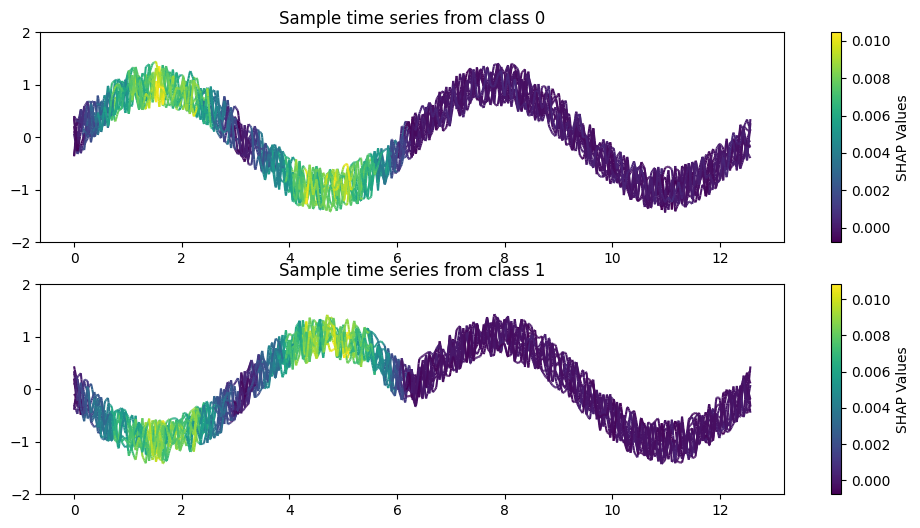

In [24]:
from tsproto.plots import plot_smooth_colored_line
import seaborn as sns

indexer = clf.predict(trainX)
shapclass = []
if absshap == False:
    for i in range(0,len(trainX)):
        best_index = indexer[i]
        shapclass.append([sv_tr[best_index][i,:]])

    shapclass=np.concatenate(shapclass)
else:
    shapclass  = sv_tr[:,0,:]
    fig, axes =plt.subplots(2,1,figsize=(12,6))
    for i in range(0,10):
        plot_smooth_colored_line(x_values=x, y_values=trainX[train_y==0][i], color_values=shapclass[train_y==0][i], resolution=1000, ax=axes[0],add_cbar=(i==0))
        plot_smooth_colored_line(x_values=x, y_values=trainX[train_y==1][i], color_values=shapclass[train_y==1][i], resolution=1000, ax=axes[1],add_cbar=(i==0))

for ax in axes:
    ax.set_ylim([-2, 2])

axes[0].set_title('Sample time series from class 0')
axes[1].set_title('Sample time series from class 1')
plt.savefig('c1c2shap.svg', format='svg',bbox_inches='tight')

## TSProto
Now, lets try to apply TSProto to see if it is able to find the prototype and summarize them correctly to show what logical relation is between them and the model prediction

In [25]:
trainXproto = trainX.reshape((trainX.shape[0], trainX.shape[1],1))
shapclassXproto = shapclass.reshape((shapclass.shape[0], shapclass.shape[1],1))

In [26]:
from tsproto.models import *
im  = InterpretableModel()
pe = PrototypeEncoder(clf, n_clusters=2, min_size=50, method='dtw',
                      descriptors=['existance'],
                      global_breakpointing=True,
                      jump=1, pen=1,multiplier=0,n_jobs=-1,
                      verbose=1)
ohe_train, features, target_ohe,weights = pe.fit_transform(trainXproto,shapclassXproto)

acc,prec,rec,f1,iclf = im.fit_or_predict(ohe_train, features, target_ohe,intclf=None, verbose=0, max_depth=2, min_samples_leaf=0.05,
                       weights=None)

ohe_test, features, target_ohe, weights = pe.transform(trainXproto,shapclassXproto)
acc,prec,rec,f1,iclf = im.fit_or_predict(ohe_test, features, target_ohe,intclf=iclf,verbose=0, max_depth=None, min_samples_leaf=0.05,
                       weights=None)

print(f'Fidelity : \n\tACC:{acc}, \n\tPREC:{prec}, \n\tREC:{rec}, \n\tF1:{f1}')
cc = DecisionTreeClassifier()
cc.fit(trainXproto[:,:,0], clf.predict(trainX))
cp = cc.predict(trainXproto[:,:,0])
f1_raw = f1_score(clf.predict(trainX), cp, average='macro')
print(f'Fidelity  RAW: {f1_raw}')

Dataset shape: (150, 200, 1)
Calculating changepoints...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Done in 0.28671741485595703.
Clustering data
Shape of data for clustering: (150, 95, 1)
Clustering data
Done in 17.149989128112793.
OHE time series
['existance']
Done in 0.5730240345001221.
Dataset shape: (150, 200, 1)
Calculating changepoints...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Done in 0.10657906532287598.
Clustering data
Shape of data for clustering: (150, 95, 1)
Done in 0.4416940212249756.
OHE time series
['existance']
Done in 1.005692958831787.
Fidelity : 
	ACC:1.0, 
	PREC:1.0, 
	REC:1.0, 
	F1:1.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fidelity  RAW: 1.0


## Visualize interpretable model
We can easily see that the TSProto has found the sine wave at the beginning of the sample, marked it as prototype and correctly identified that its existence is enough to treat the sample as a class 1 sample

TC: 75 over ccshap: 75


/usr/local/lib/python3.12/dist-packages/tsproto/plots.py:274: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[-1].legend()


Decision Tree exported to synthetic with embedded histograms successfully.


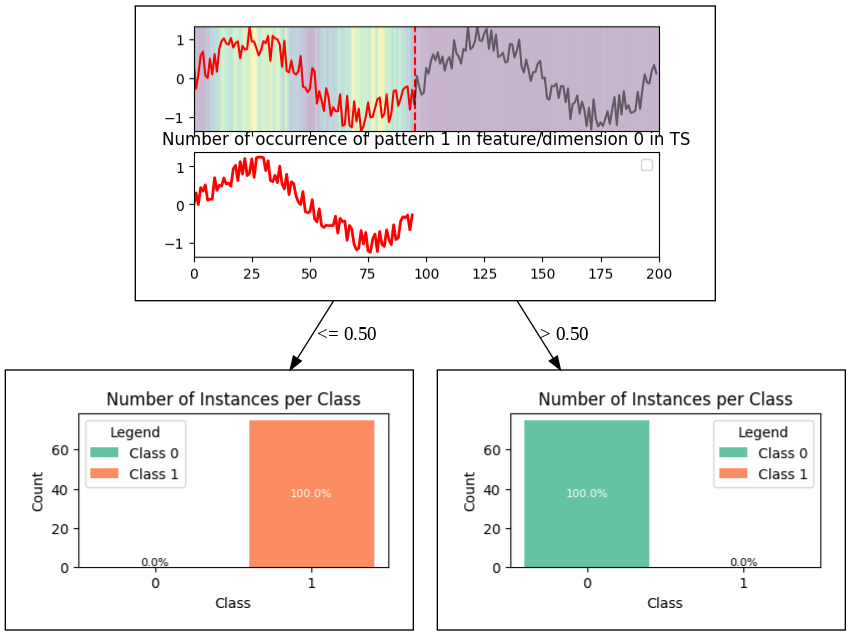

In [27]:
from  tsproto.plots import *

ds_final = ohe_train.copy()
dot = export_decision_tree_with_embedded_histograms(decision_tree=iclf,
                                              dataset=ds_final,
                                              target_name='target',
                                              feature_names=features,
                                              filename='synthetic',
                                              proto_encoder=pe, figsize=(6,3))

from IPython.display import SVG, Image
Image('synthetic.png')